# SQUID: $V$-$\Phi$ characteristics
Thomas D. Schanzer  
July 2022

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.odr import RealData, ODR, Model

matplotlib.rcParams['font.family'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'

In [78]:
def sinusoid(x, period, peak2peak, phase, offset):
    return peak2peak/2*np.sin(2*np.pi*x/period - phase) + offset

sinusoid_model = Model(lambda beta, x: sinusoid(x, *beta))

def fit_params(file):
    df = pd.read_csv(file)
    current = df['0_x'].to_numpy()
    voltage = df['0_y'].to_numpy()

    # put the current values in ascending order (order is irrelevant)
    idx = np.argsort(current)
    current = current[idx]
    voltage = voltage[idx]

    data = RealData(current, voltage, sx=1, sy=1)
    output = ODR(data, sinusoid_model, beta0=(100, 10, np.pi, 0)).run()
    return current, voltage, output.beta, output.sd_beta
    
def eval_fit(current, voltage, params):
    fit = sinusoid(current, *params)
    residuals = voltage - fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((voltage - voltage.mean())**2)
    r_squared = 1 - ss_res/ss_tot
    return fit, residuals, r_squared

In [98]:
delta_V, d_delta_V = np.zeros(11), np.zeros(11)
delta_I, d_delta_I = np.zeros(11), np.zeros(11)
for i in range(11):
    _, _, params, d_params = fit_params(
        f'../data/21072022/VPhi_21072022_{i}.csv')
    delta_I[i], d_delta_I[i] = params[0], d_params[0]
    delta_V[i], d_delta_V[i] = params[1], d_params[1]
    
current, voltage, params, d_params = fit_params(
    f'../data/21072022/VPhi_21072022_6.csv')
fit, residuals, r_squared = eval_fit(current, voltage, params)

In [105]:
def add_number(ax, text):
    ax.text(
        0.05, 0.87, text, transform=ax.transAxes, fontsize=16,
        fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
    )

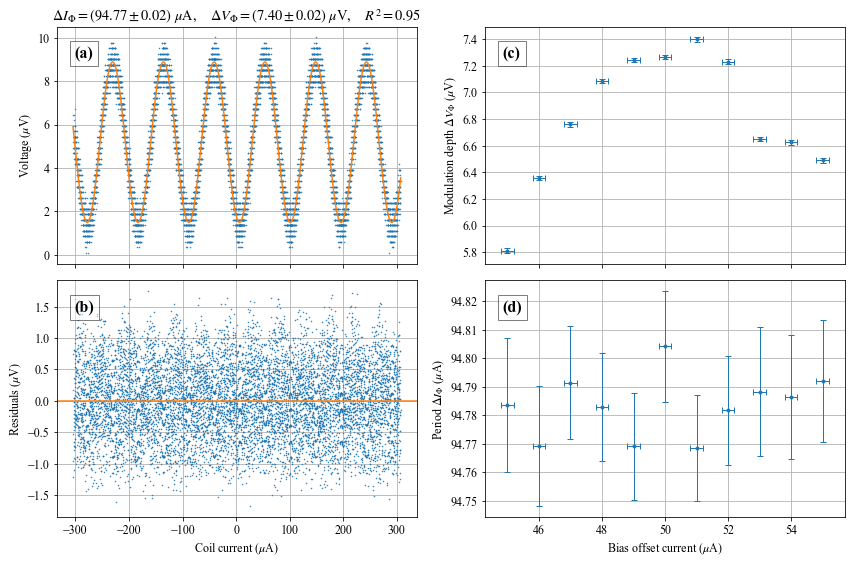

In [109]:
bias_offset = np.arange(45., 56., 1.)
fig, axes = plt.subplots(2, 2, figsize=(12,8), sharex='col')

axes[0,0].plot(current, voltage, '.', markersize=1)
axes[0,0].plot(current, fit)
title = (
    '$\Delta I_\Phi = ({:.2f} \\pm {:.2f})$ $\mu$A,    '
    '$\Delta V_\Phi = ({:.2f} \\pm {:.2f})$ $\mu$V,    '
    '$R^2 = {:.2f}$'
).format(params[0], d_params[0], params[1], d_params[1], r_squared)
axes[0,0].set(ylabel='Voltage ($\mu$V)', title=title)
axes[0,0].grid()
add_number(axes[0,0], '(a)')

axes[1,0].plot(current, residuals, '.', markersize=1)
axes[1,0].axhline(0, color='tab:orange')
axes[1,0].grid()
axes[1,0].set(xlabel='Coil current ($\mu$A)', ylabel='Residuals ($\mu$V)')
add_number(axes[1,0], '(b)')

axes[0,1].errorbar(
    bias_offset, delta_V, xerr=0.2, yerr=d_delta_V,
    marker='.', linestyle='', elinewidth=1, capsize=3)
axes[0,1].grid()
axes[0,1].set(ylabel='Modulation depth $\Delta V_\Phi$ ($\mu$V)')
add_number(axes[0,1], '(c)')

axes[1,1].errorbar(
    bias_offset, delta_I, xerr=0.2, yerr=d_delta_I,
    marker='.', linestyle='', elinewidth=1, capsize=3)
axes[1,1].grid()
axes[1,1].set(xlabel='Bias offset current ($\mu$A)',
              ylabel='Period $\Delta I_\Phi$ ($\mu$A)')
add_number(axes[1,1], '(d)')

fig.tight_layout()
fig.savefig('../figures/vphi.pdf', bbox_inches='tight')

In [111]:
delta_I.mean(), delta_I.std()

(94.7833749123058, 0.010589713023425009)